# Imbalance handling and classification

## Step 1 - Required Libraries
The libraries required for performing different tasks through this project are imported

In [253]:
## Genral computational requirements
import pandas as pd
import numpy as np

## Prepocessing requirements
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection
from imblearn.over_sampling import SMOTE

## Visualisation requirements
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

## Model building and evaluation requirements
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

## Hyper parameter tuning
from sklearn.model_selection import GridSearchCV


## Step 2 -Import the dataset to dataframe
The android permission dataset used in this project is stored locally, which is imported and stored in a pandas dataframe

In [226]:
perm_data = pd.read_csv('D:/MTU MSc DSA/Semester 2/Applied ML/Assignment 3/Dataset/Android_Permission.csv')

In [227]:
print("Shape of the input dataframe: ",perm_data.shape)
print("\n\nSummary of the dataframe: ")
perm_data.describe()

Shape of the input dataframe:  (29999, 184)


Summary of the dataframe: 


,Rating,Number of ratings,Price,Dangerous permissions count,Safe permissions count,Default : Access DRM content. (S),Default : Access Email provider data (S),Default : Access all system downloads (S),Default : Access download manager. (S),Default : Advanced download manager functions. (S),...,Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S),Class
count,29999.000000,2.999900e+04,29999.000000,29795.000000,29999.000000,29999.000000,29999.000000,29999.0,29999.000000,29999.000000,...,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000
mean,3.537215,6.852608e+03,0.625707,3.111160,1.353978,0.000300,0.000700,0.0,0.000400,0.000033,...,0.014667,0.087970,0.023801,0.001333,0.000567,0.000400,0.016567,0.039735,0.001500,0.666689
std,1.424685,4.586899e+04,3.222620,3.052602,1.523491,0.017318,0.026449,0.0,0.019997,0.005774,...,0.120219,0.283255,0.152431,0.036492,0.023799,0.019997,0.127645,0.195338,0.038702,0.471405
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.300000,4.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,4.600000e+01,0.000000,2.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,4.400000,7.160000e+02,0.000000,4.000000,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,5.000000,1.908590e+06,158.070000,30.000000,16.000000,1.000000,1.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Step 3 -Data Preprocessing
The dataset dealt with is a binary classification requirement, which consists of 184 columns. The following steps are to be carried out in preprocessing the dataset before model building

-> Handling Null values

-->Feature Scaling

-->One hot encoding

-->Selecting only required feature variables

-->Imbalance handling

### Step 3.1 - Handling null values
The dataset consists of a total of 3.21 % of na values, which are dropped

In [228]:
data_cols = perm_data.columns
features = perm_data[data_cols]
print("***Handling Null Values***\n")

## Counting the total number of na values and further checking number of na values column-wise
print("\nTotal number of null values based on columns:")
for i in data_cols:
    if perm_data[i].isna().sum() > 0:
        print(i,perm_data[i].isna().sum())
print("\nTotal number of rows with Null values:",perm_data.isnull().sum().sum())
print("Total percentage of Null values in dataframe: ",round(perm_data.isnull().sum().sum() * 100 / len(perm_data),2), "%")

## From the information obtained above, only rows with not na values are retrained have the remaining are left off
print("\n\n***Removing rows with null values***")
feat_nona = perm_data[perm_data['Dangerous permissions count'].notna()]
feat_nona = feat_nona[feat_nona['App'].notna()]
feat_nona = feat_nona[feat_nona['Description'].notna()]
feat_nonan = feat_nona[feat_nona['Related apps'].notna()]

print("\nTotal number of rows with Null values after handling:",feat_nonan.isnull().sum().sum())

***Handling Null Values***


Total number of null values based on columns:
App 1
Description 3
Related apps 755
Dangerous permissions count 204

Total number of rows with Null values: 963
Total percentage of Null values in dataframe:  3.21 %


***Removing rows with null values***

Total number of rows with Null values after handling: 0


### Step 3.2 - Selecting required feature and target variables
The following columns are removed from the dataframe App, Package, Related Apps and Description.
Only 'Category' qualitative column is considered, which too has been one hot encoded in the following steps

In [229]:
data_cols = feat_nonan.iloc[:,np.r_[0,2,4:7,8:183]].columns
label_col = feat_nonan.columns[183]
feat_nona = feat_nonan[data_cols]
labels = feat_nonan[label_col]

### Step 3.3 - Feature scaling
Standardising the data to a common scale with mean tending to be 0 and standard deviation tending to be 1. This is done particularly as three columns Rating, Number of rating and price are all of different scales

In [230]:
print('***Standardizing the dataset***\n\n')
pd.options.mode.chained_assignment = None
print("Mean value of all numerical columns combined before scaling: ",feat_nona.select_dtypes(exclude=['object']).stack().mean())
print("Standard deviation value of all numerical columns combined before scaling: ",feat_nona.select_dtypes(exclude=['object']).stack().std())
print("\n\n**Performing data scaling**")

## Using the sklearn standardscaler to standardise the dataset
stan_scale = StandardScaler()
numeric_dataset = feat_nona.select_dtypes(exclude=['object']) ## Removing the qualitative text columns from the process
feat_nona[numeric_dataset.columns] = stan_scale.fit_transform(numeric_dataset) ## transforming the dataset to common scale

## Checking for the mean and standard deviation after standardising the dataset
print("Mean value of all numerical columns combined after scaling: ",feat_nona.select_dtypes(exclude=['object']).stack().mean())
print("Standard deviation value of all numerical columns combined after scaling: ",feat_nona.select_dtypes(exclude=['object']).stack().std())

***Standardizing the dataset***


Mean value of all numerical columns combined before scaling:  39.03999020696701
Standard deviation value of all numerical columns combined before scaling:  3484.509649885531


**Performing data scaling**
Mean value of all numerical columns combined after scaling:  3.678007874119121e-16
Standard deviation value of all numerical columns combined after scaling:  0.9361648694455973


### Step 3.4 - One hot encoding
Category column which is a text is transformed using one hot encoding, the number of categories are pivoted to columns with binary values assigned to each row.

In [231]:
encoder = OneHotEncoder(sparse=False) ## One hot encoder from sklear used 
departmentEncoded = encoder.fit_transform( feat_nona[["Category"]]) ## Category column processed through the model
encoded_df = pd.DataFrame(departmentEncoded, columns=encoder.get_feature_names_out())

## Reindexing the dataframes before combining again
feat_nona.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

## Category column dropped, one hot encoded numerical columns concatenated with the orginal dataframe
feat_nona_encoded = pd.concat([feat_nona, encoded_df], axis=1).drop(['Category'], axis=1)

In [232]:
print("Unique values of category column: \n",feat_nona.Category.unique())
print("\nDataframe after one hot encoding: ")
feat_nona_encoded.head(2)

Unique values of category column: 
 ['Business' 'Brain & Puzzle' 'Cards & Casino' 'Libraries & Demo'
 'Personalization' 'Arcade & Action' 'Social' 'Health & Fitness'
 'Entertainment' 'Casual' 'Media & Video' 'Finance' 'Music & Audio'
 'Books & Reference' 'Tools' 'Education' 'Shopping' 'Travel & Local'
 'Lifestyle' 'Sports' 'Racing' 'Productivity' 'Communication'
 'Transportation' 'Comics' 'Medical' 'Sports Games' 'Photography'
 'News & Magazines' 'Weather']

Dataframe after one hot encoding: 


,App,Rating,Number of ratings,Price,Dangerous permissions count,Safe permissions count,Default : Access DRM content. (S),Default : Access Email provider data (S),Default : Access all system downloads (S),Default : Access download manager. (S),...,Category_Productivity,Category_Racing,Category_Shopping,Category_Social,Category_Sports,Category_Sports Games,Category_Tools,Category_Transportation,Category_Travel & Local,Category_Weather
0,Canada Post Corporation,-0.365499,-0.149199,-0.181443,1.262883,-0.240454,-0.017547,-0.026809,0.0,-0.020262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Word Farm,0.518860,-0.146546,-0.181443,-0.040600,0.412548,-0.017547,-0.026809,0.0,-0.020262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Step 4 - Data Split
The dataset is split into train, validation and test, where the train dataset will be used for model training with the validation used for model evaluation in development phase.

The test dataset will be used as the unknown/unseen dataset for prediction with the final best model

Train, test split: 80% of total data as train 20% as test

Train, validation split: 80% of train data as train, 20% as validation

In [233]:
feat_nona_encoded = feat_nona_encoded.iloc[:,np.r_[1:209]] ## The app column which is no longer required is removed here
train_features, test_features, train_labels, test_labels = model_selection.train_test_split(feat_nona_encoded, labels, test_size=0.2, random_state=0)
train_features, val_features, train_labels, val_labels = model_selection.train_test_split(train_features, train_labels, test_size=0.2, random_state=0)

## Checking the orginal, train, validation and test dataset shapes
print("Train, Validation and test split dataframes size: ")
print("\nOrginal dataset and labels shape: ",feat_nona_encoded.shape,labels.shape)
print("Train dataset and labels shape: ",train_features.shape,train_labels.shape)
print("Validation dataset and labels shape: ",val_features.shape,val_labels.shape)
print("Test dataset and labels shape: ",test_features.shape,test_labels.shape)

Train, Validation and test split dataframes size: 

Orginal dataset and labels shape:  (29240, 208) (29240,)
Train dataset and labels shape:  (18713, 208) (18713,)
Validation dataset and labels shape:  (4679, 208) (4679,)
Test dataset and labels shape:  (5848, 208) (5848,)


## Step 5 - Imbalance handling
The dataset is highly imbalanced, in this step the imbalance is visualised and then is handled using SMOTE technique.

The effect of imbalance handling is shown by training and evaluating a random forest model before and after applying SMOTE imbalance handling on the dataset

#### Step 5.1 - Visualising imabalance in the dataset
Checking the percentage of imbalance between the classes 0 and 1 using a pie chart, before applying SMOTE

Malware and Not malware data percentage:
Number of apps categorised as Malware: 12390 (66.21%)
Number of apps categorised as Not-Malware: 6323 (33.79%)


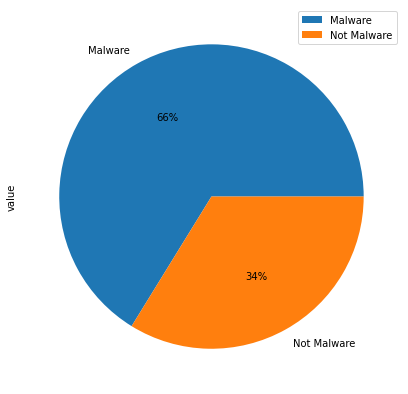

In [235]:
categories = []
for i in train_labels:
    if i==0:
        categories.append('Not Malware')
    else:
        categories.append('Malware')
        
## Classifying malware and not malware        
lab_df =pd.DataFrame({
    'value': train_labels,
    'categories':categories
})
    
ob_len=len(lab_df)
malware= len(lab_df.loc[lab_df['value'] == 1])
not_mal= len(lab_df.loc[lab_df['value'] == 0])
print('Malware and Not malware data percentage:')
print('Number of apps categorised as Malware: {0} ({1:.2f}%)'.format(malware, (malware/ob_len)*100))
print('Number of apps categorised as Not-Malware: {0} ({1:.2f}%)'.format(not_mal, (not_mal/ob_len)*100))

## Plotting a pie chat for the classes 0 and 1
lab_df.groupby('categories').count().plot(kind = 'pie', y = 'value', autopct = '%1.0f%%', figsize=(7,7))
plt.show()

#### Step 5.2 - RF model training on imbalanced dataset
Training a random forest model and evaluating the accuracy before handling the imbalance in the dataset

In [236]:
cl_rf_bfsme = RandomForestClassifier(max_depth=2, random_state=0).fit(train_features, train_labels)
scores_rf_bfsme = cross_val_score(cl_rf_bfsme, train_features, train_labels, cv=10, scoring='f1_macro')

Random Forest Model training - before imbalance handling
39.84 accuracy for 10 F-CV Random Forest

Prediction on validation dataset


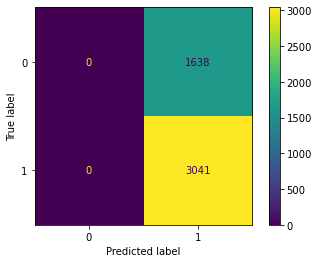

In [237]:
print("Random Forest Model training - before imbalance handling")
print("%0.2f accuracy for 10 F-CV Random Forest" % (scores_rf_bfsme.mean()*100))

print("\nPrediction on validation dataset")
## Prediction on valdiation dataset
predictions_rf_bfsme = cl_rf_bfsme.predict(val_features)
cm_rf_bfsme = confusion_matrix(val_labels, predictions_rf_bfsme)
##Creating conusion matrix for validation
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_bfsme)
disp.plot()
plt.show()

### Step 5. 3 - Performing SMOTE to handle imbalance

In [238]:
sm = SMOTE(random_state=42)
train_features_x, train_labels_y = sm.fit_resample(train_features, train_labels)

#### Step 5.4 - Visualising imabalance in the dataset
Checking the percentage of imbalance between the classes 0 and 1 using a pie chart, after applying SMOTE

Malware and Not malware data percentage:
Number of apps categorised as Malware: 12390 (50.00%)
Number of apps categorised as Not-Malware: 12390 (50.00%)


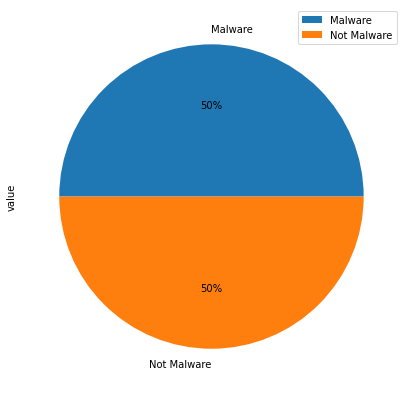

In [239]:
categories = []
for i in train_labels_y:
    if i==0:
        categories.append('Not Malware')
    else:
        categories.append('Malware')
        
## Classifying malware and not malware        
lab_df =pd.DataFrame({
    'value': train_labels_y,
    'categories':categories
})
    
ob_len=len(lab_df)
malware= len(lab_df.loc[lab_df['value'] == 1])
not_mal= len(lab_df.loc[lab_df['value'] == 0])
print('Malware and Not malware data percentage:')
print('Number of apps categorised as Malware: {0} ({1:.2f}%)'.format(malware, (malware/ob_len)*100))
print('Number of apps categorised as Not-Malware: {0} ({1:.2f}%)'.format(not_mal, (not_mal/ob_len)*100))

## Plotting a pie chat for the classes 0 and 1
lab_df.groupby('categories').count().plot(kind = 'pie', y = 'value', autopct = '%1.0f%%', figsize=(7,7))
plt.show()

#### Step 5.5 - RF model training on balanced dataset
Training a random forest model and evaluating the accuracy after handling the imbalance in the dataset

In [240]:
cl_rf_afsme = RandomForestClassifier(max_depth=2, random_state=0).fit(train_features_x, train_labels_y)
scores_rf_afsme = cross_val_score(cl_rf_bfsme, train_features_x, train_labels_y, cv=10, scoring='f1_macro')

Random Forest Model training - after imbalance handling
78.56 accuracy for 10 F-CV Random Forest

Prediction on validation dataset


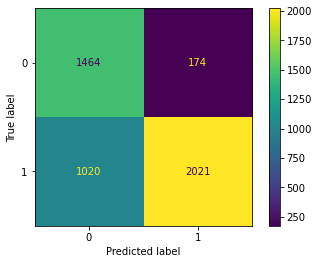

              precision    recall  f1-score   support

           0       0.59      0.89      0.71      1638
           1       0.92      0.66      0.77      3041

    accuracy                           0.74      4679
   macro avg       0.76      0.78      0.74      4679
weighted avg       0.80      0.74      0.75      4679



In [278]:
print("Random Forest Model training - after imbalance handling")
print("%0.2f accuracy for 10 F-CV Random Forest" % (scores_rf_afsme.mean()*100))

print("\nPrediction on validation dataset")
predictions_rf = cl_rf_afsme.predict(val_features)
cm_rf = confusion_matrix(val_labels, predictions_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot()
plt.show()
print(classification_report(val_labels, predictions_rf))


# Step 6 - Model Training

#### Step 6.1 - Naive Bayes

In [148]:
clf_nv_ber = BernoulliNB().fit(train_features_x, train_labels_y)
scores_nv_ber= cross_val_score(clf_nv_ber, train_features_x, train_labels_y, cv=10, scoring='f1_macro')

Naive Bayes Model training
74.24 accuracy for 10 F-CV Naive Bayes

Prediction on validation dataset


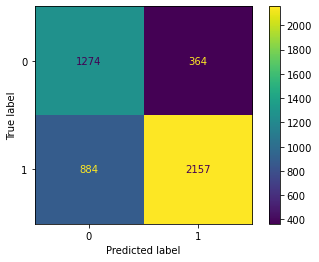

In [149]:
print("Naive Bayes Model training")
print("%0.2f accuracy for 10 F-CV Naive Bayes" % (scores_nv_ber.mean()*100))

print("\nPrediction on validation dataset")
predictions_nv = clf_nv_ber.predict(val_features)
cm_nv = confusion_matrix(val_labels, predictions_nv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nv)
disp.plot()
plt.show()

#### Step 6.2 - SVM - Support vector machines

In [152]:
clf_svm = SVC(kernel='linear', C=1).fit(train_features_x, train_labels_y)
scores_svm = cross_val_score(clf_svm, train_features_x, train_labels_y, cv=10)

SVM Model training
77.23 accuracy for 10 F-CV SVM

Prediction on validation dataset


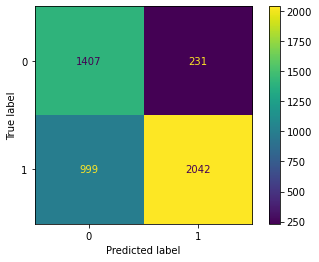

In [154]:
print("SVM Model training")
print("%0.2f accuracy for 10 F-CV SVM" % (scores_svm.mean()*100))

print("\nPrediction on validation dataset")
predictions_svm = clf_svm.predict(val_features)
cm_svm = confusion_matrix(val_labels, predictions_svm, labels=clf_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=clf_svm.classes_)
disp.plot()
plt.show()

#### Step 6.3 - K-Nearest Neighbors Algorithm - KNN

In [248]:
clf_knn = KNeighborsClassifier(n_neighbors=3).fit(train_features_x, train_labels_y)
scores_knn = cross_val_score(clf_knn, train_features_x, train_labels_y, cv=10)

KNN Model training
76.99 accuracy for 10 F-CV KNN

Prediction on validation dataset


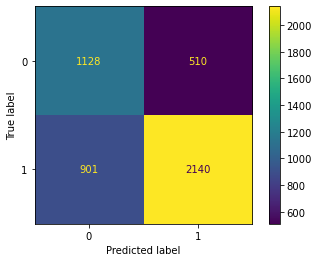

In [249]:
print("KNN Model training")
print("%0.2f accuracy for 10 F-CV KNN" % (scores_knn.mean()*100))

print("\nPrediction on validation dataset")
predictions_knn = clf_knn.predict(val_features)
cm_knn = confusion_matrix(val_labels, predictions_knn, labels=clf_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=clf_knn.classes_)
disp.plot()
plt.show()

# Step 7 - Hyperparameter tuning

In [254]:
hyper = {'n_estimators': [100,300], 'criterion': ["gini", "entropy"],'max_features': ["auto","sqrt"],'n_jobs': [1,-1], 'oob_score': ['TRUE']}

## Using gridsearch cv to find the best fit model
gd_hyper=GridSearchCV(estimator=RandomForestClassifier(),param_grid=hyper,cv=10, scoring='f1_macro')

gd_hyper.fit(train_features_x, train_labels_y)

print("Best Score: ", gd_hyper.best_score_)
print("Best Estimatior: ", gd_hyper.best_estimator_)

Best Score:  0.8526238336717251
Best Estimatior:  RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=300, n_jobs=-1, oob_score='TRUE')


Random Forest Model training - hyperparameter tuning
85.26 accuracy for 10 F-CV Random Forest

Prediction on validation dataset


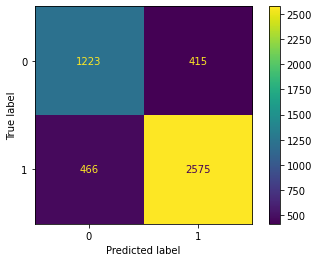

              precision    recall  f1-score   support

           0       0.72      0.75      0.74      1638
           1       0.86      0.85      0.85      3041

    accuracy                           0.81      4679
   macro avg       0.79      0.80      0.79      4679
weighted avg       0.81      0.81      0.81      4679



In [280]:
print("Random Forest Model training - hyperparameter tuning")
print("%0.2f accuracy for 10 F-CV Random Forest" % (gd_hyper.best_score_*100))

print("\nPrediction on validation dataset")
predictions_rf_hyp = gd_hyper.predict(val_features)
cm_rf_hyp = confusion_matrix(val_labels, predictions_rf_hyp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_hyp)
disp.plot()
plt.show()
print(classification_report(val_labels, predictions_rf_hyp))

# Step 8 - Model evaluation and comparision

The Model accuracy summary:


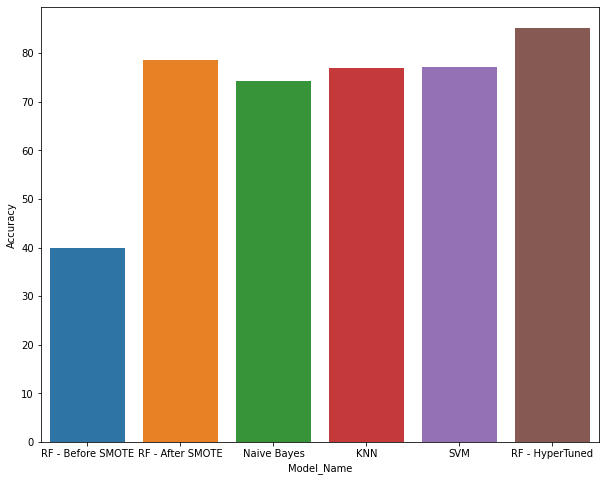

,Model_Name,Accuracy
0,RF - Before SMOTE,39.835387
1,RF - After SMOTE,78.564294
2,Naive Bayes,74.235370
3,KNN,76.985472
4,SVM,77.231638
5,RF - HyperTuned,85.262383


In [258]:
data_input = {'Model_Name': ['RF - Before SMOTE','RF - After SMOTE','Naive Bayes','KNN','SVM','RF - HyperTuned'],
        'Accuracy': [scores_rf_bfsme.mean()*100,scores_rf_afsme.mean()*100,scores_nv_ber.mean()*100,scores_knn.mean()*100,scores_svm.mean()*100,gd_hyper.best_score_*100]}

Accuracy_Df = pd.DataFrame(data_input)

## Plotting the model accuracy of all trained models
print("The Model accuracy summary:")
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='Model_Name', y='Accuracy', data=Accuracy_Df, saturation=0.8)
plt.show()
Accuracy_Df

# Step 9 - Prediction on test dataset

In [274]:
## Predicting the unseen test dataset
prediction_test = (gd_hyper.predict(test_features) > 0.5).astype("int32")

Pred_values =pd.DataFrame({
    'Actual': test_labels,
    'Predicted':prediction_test
    
})

Confusion matrix for test dataset prediction

Prediction on Test dataset


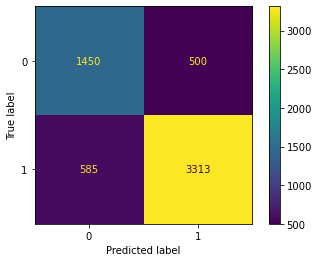

              precision    recall  f1-score   support

           0       0.71      0.74      0.73      1950
           1       0.87      0.85      0.86      3898

    accuracy                           0.81      5848
   macro avg       0.79      0.80      0.79      5848
weighted avg       0.82      0.81      0.82      5848



,Actual,Predicted
5848,0,1
15374,1,1
19714,1,1
24400,0,1
21379,1,1
...,...,...
10415,1,1
21240,0,1
18411,0,0
4169,1,1


In [275]:
print("Confusion matrix for test dataset prediction")

print("\nPrediction on Test dataset")
cm_rf = confusion_matrix(Pred_values.Actual, Pred_values.Predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot()
plt.show()
print(classification_report(Pred_values.Actual, Pred_values.Predicted))
Pred_values